1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
npr.seed(123)

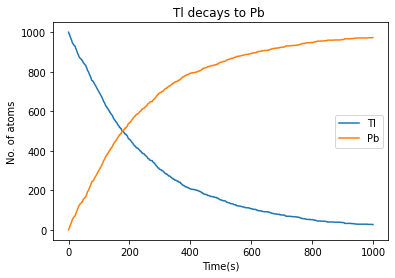

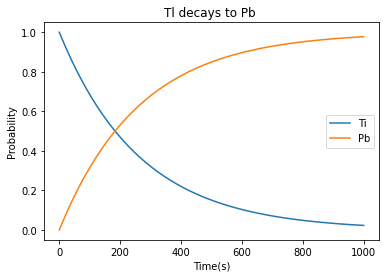

In [2]:
tau = 3.052*60 

#sample of 1000 Thallium atoms
Tl_samp = 1000 
#sample of 0 of Lead atoms
Pb_samp = 0 

def prob(t):
    return 1-2**(-t/tau)

#Return random floats in the half-open interval [0.0, 1.0)
ch = npr.random(Tl_samp)

t = range(0, 1000)

Tl = np.array([(prob(t) < ch).sum() for t in t])
Pb = 1000 - Tl

plt.plot(t,Tl,label='Tl')
plt.plot(t,Pb,label='Pb')
plt.title("Tl decays to Pb ")
plt.xlabel("Time(s)")
plt.ylabel("No. of atoms")
plt.legend(loc='best')
plt.show()

t = np.linspace(0,1000)
yTl_law = np.exp2(-t/tau)
plt.plot(t, yTl_law, label='Ti')
yPb_law = 1-np.exp2(-t/tau) 
plt.plot(t, yPb_law, label='Pb')
plt.title("Tl decays to Pb ")
plt.xlabel("Time(s)")
plt.ylabel("Probability")
plt.legend(loc='best')
plt.show()

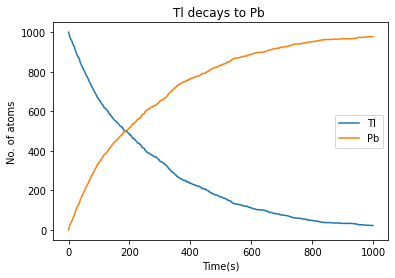

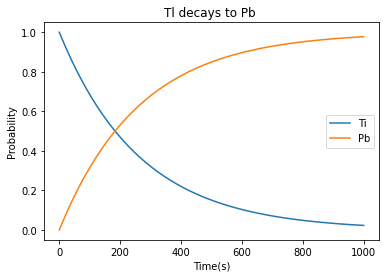

In [3]:
tau = 3.052*60 

#sample of 1000 Thallium atoms
Tl_samp = 1000 
#sample of 0 of Lead atoms
Pb_samp = 0 

def prob(t):
    return -tau * np.log2(1-t)

#Return random floats in the half-open interval [0.0, 1.0)
ch = npr.random(Tl_samp)

t = range(0, 1000)

Tl = np.array([(prob(ch) > t).sum() for t in t])
Pb = 1000 - Tl

plt.plot(t,Tl,label='Tl')
plt.plot(t,Pb,label='Pb')
plt.title("Tl decays to Pb ")
plt.xlabel("Time(s)")
plt.ylabel("No. of atoms")
plt.legend(loc='best')
plt.show()

t = np.linspace(0,1000)
yTl_law = np.exp2(-t/tau)
plt.plot(t, yTl_law, label='Ti')
yPb_law = 1-np.exp2(-t/tau) 
plt.plot(t, yPb_law, label='Pb')
plt.title("Tl decays to Pb ")
plt.xlabel("Time(s)")
plt.ylabel("Probability")
plt.legend(loc='best')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
# constant 
Z = 79
e = 1.6e-19
eps0 = 8.854e-12
E = 7.7e6*e
a0 = 5.29e-11
N = int(1e6)
sig = a0/100

d = np.random.random(N)
b = np.sqrt(-2*sig**2*np.log(1-d))

theta = 2*np.arctan((Z*e**2)/(2*np.pi*eps0*E*b))

bounce_back = len(theta[theta > np.pi/2])

fract = bounce_back/N

print("Fraction of particles bounce back: ", fract)


Fraction of particles bounce back:  0.001535


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [5]:
# hit/miss
def f(x):
    return (np.sin(1/(x*(2-x))))**2

x=np.linspace(0.001,1.999,1000)

N=100000
count=0
for i in range(N):
    x=np.random.random()
    y=np.random.random()
    if y<f(x): count+=1
I=2 * count/N

p = count/N                         
error_hm = 2*np.sqrt(N*p*(1-p))/N 

print("Integral value with hit/miss method:  %.4f +- %.4f " %(I,error_hm))

# mean value 

x = np.random.uniform(size=N)
I = (2/N)*sum(f(x))
error_mean = 2*np.sqrt(np.var(f(x))/N)

print("Integral value with mean value method:  %.4f +- %.4f " %(I,error_mean))

Integral value with hit/miss method:  1.4549 +- 0.0028 
Integral value with mean value method:  1.4521 +- 0.0017 


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [6]:
#Monte Carlo without for loop

N = 1000000

x = npr.uniform(-1.0,1.0,N)
y = npr.uniform(-1.0,1.0,N)

fun = x**2+y**2

p = len(fun[np.sqrt(fun)<=1])

a = 4*(p/N)

print("The area of a circle of unit radius: %.2f " % a)

The area of a circle of unit radius: 3.14 


In [7]:
# 10D

def n_volume(dim, n , radius ):
    
    points = npr.uniform(-1.0, 1.0, size=[n,dim])
    
    distance = np.linalg.norm (points, axis = 1)
    p = len(distance[distance<=radius])
    
    return np.power(2.0*radius, dim) * (p / n)

print("Volume of a 10D sphere is : ",n_volume(10, 1000000, 1.))

Volume of a 10D sphere is :  2.54464


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [12]:
def w(x):
    return 1/(2*np.sqrt(x))

def f(x):
    return w(x)/(np.exp(x)+1)

n = int(1e7)
x = stats.powerlaw(0.5).rvs(n)
I = (np.sum(f(x)/w(x))*2)/n
print('The estimated integral value is: %.2f'%(I))

The estimated integral value is: 0.84
The estimated integral value is: 0.84
